---
format:
  html:
    code-line-numbers: true
    code-overflow: wrap
    code-block-bg: true
    code-block-border-left: true
    highlight-style: Arrow
---

# The N-queens Problem {#sec-nqueens}

The n-queens problem is a classic puzzle that involves placing $n$ queens on an $n \times n$ chessboard in such a way that no two queens threaten each other. In other words, no two queens can be placed on the same row, column, or diagonal. The problem is called the $n$-queens problem because it can be generalized to any size of $n$.

For example, the 8-queens problem involves placing 8 queens on an 8x8 chessboard, and the solution requires that no two queens share the same row, column, or diagonal.

The n-queens problem is a well-known problem in computer science and has been studied extensively because it has applications in various fields, such as optimization, artificial intelligence, and computer graphics. There are various algorithms and techniques that can be used to solve the n-queens problem, including brute-force search, backtracking, and genetic algorithms.
In this chapter, we'll model this problem as an integer programming problem and solve it using OR-Tools.

To model this problem on an $n \times n$ chessboard, we define the following decision variable:

- $x_{ij}$: a binary variable that equals 1 if a queen is place on position $(i, j)$, where $i, j = 0, \cdots, n-1$; and 0 otherwise

The complete model given below is based on @letavec_n_2002.

\begin{align}
    \text{max.} &\quad 0 \label{nq-obj}\\
    \text{s.t.} &\quad \sum_{i=0}^{n-1} \sum_{j=0}^{n-1} x_{ij} = n \label{nq-cons1} \\
    &\quad \sum_{j=0}^{n-1} x_{ij} \leq 1, \ \forall i = 0, \cdots, n-1 \label{nq-cons2} \\
    &\quad \sum_{i=0}^{n-1} x_{ij} \leq 1, \ \forall j = 0, \cdots, n-1 \label{nq-cons3}\\
    &\quad \sum_{i=0}^{n-1} \sum_{j=0, i+j=k}^{n-1} x_{ij} \leq 1, \ \forall k = 1, \cdots, 2(n-1) - 1 \label{nq-cons4}\\
    &\quad \sum_{i=0}^{n-1} \sum_{j=0, i-j=k}^{n-1} x_{ij} \leq 1, \ \forall k = 2-n, \cdots, n-2 \label{nq-cons5}\\
    &\quad x_{ij} \in \{0, 1\},\  i, j = 0, \cdots, n-1
\end{align}

In the formulation, the objective function \eqref{nq-obj} serves no practical use as our goal is to find any feasible solution to the puzzle.
Constraints \eqref{nq-cons1} require that there are exactly $n$ queens be placed on a board of size $n \times n$.
Constraints \eqref{nq-cons2} make sure that there is at most one queen be placed in any row of the board.
Similarly, constraints \eqref{nq-cons3} ensure that there is at most one queen be placed in any column of the board.
To understand constraints \eqref{nq-cons4} and \eqref{nq-cons5}, let's look at a 8-queens solution in @fig-8-queens-sol-example.

Note that no two queens can be placed on the same diagonal anywhere on the board.
Upon observing the chessboard, we can see that there are two types of diagonals:

- Diagonals that start from the upper left corner and move to the bottom right corner
  - Positions (1, 0), (0, 1) form a diagonal - sum of position coordinates = 1
  - Positions (2, 0), (1, 1), (0, 2) form a diagonal - sum of position coordinates = 2
  - ...
  - Positions (7, 6), (6, 7) form a diagonal - sum of position coordinates = 2 * (8 - 1) - 1
- Diagonals that start from the upper right corner and move to the bottom left corner
  - Positions (0, 6), (1, 7) form a diagonal - difference of position coordinates = -6
  - Positions (0, 5), (1, 6), (2, 7) form a diagonal - difference of position coordinates = -5
  - ...
  - Positions (6, 0), (7, 1) form a diagonal - difference of position coordinates = 8 - 2

The first type of diagonals can be expressed as constraints \eqref{nq-cons4} and the second type of diagonals can be expressed as constraints \eqref{nq-cons5}.
Both constraints guarantee that there cannot be any two queens showing up in the same diagonal.

In [64]:
#| echo: false

import sys
import numpy as np
sys.setrecursionlimit(10**6)
import matplotlib.pyplot as plt

class ChessBoard:
    """taken from: https://github.com/mostafa-k-m/N-Queens-Problem-Solution
    """
    def __init__(self, size):
        board = np.zeros((size,size))
        board[1::2,0::2] = 1
        board[0::2,1::2] = 1
        self.board = board
        self.size = size

    def make_board(self):
        fig, ax = plt.subplots(figsize=(10,10))
        ax.imshow(self.board, cmap='binary')
        ticks = [i for i in range(0, self.size)]
        ax.set(xticks = ticks, yticks = ticks)
        self.ax = ax

    def display(self, q_coordinates):
        fontsize = 100 - self.size*4 if 100 - self.size*4 > 10 else 15
        self.make_board()
        ax = self.ax
        for i in q_coordinates:
            ax.text(i[1], i[0],'♕', fontsize=fontsize, ha='center', va='center', color='black' if (i[0] - i[1]) % 2 == 0 else 'white')
        return ax

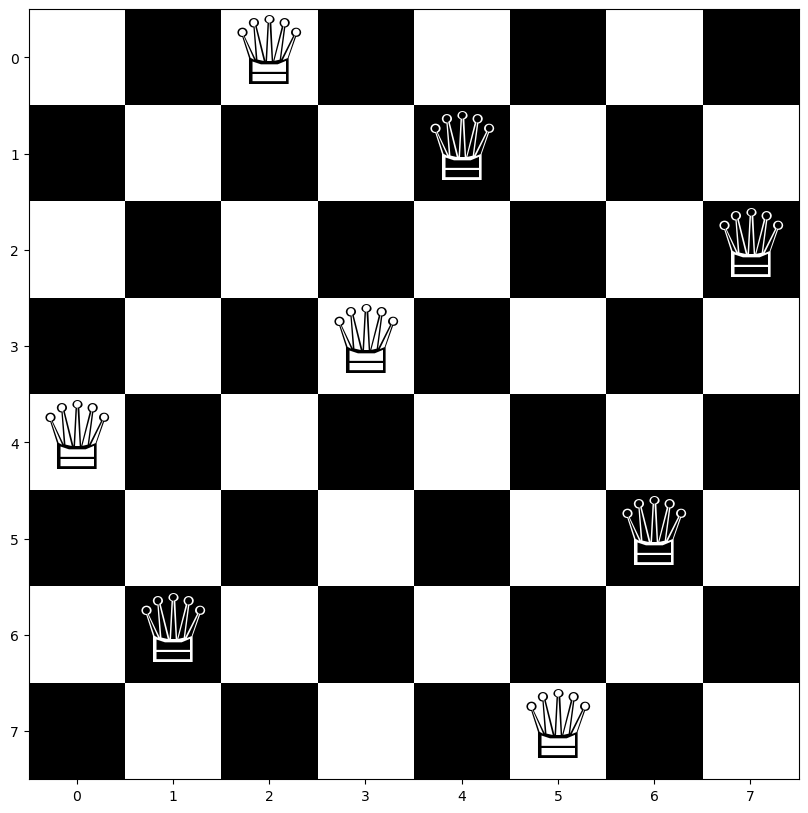

In [60]:
#| echo: false
#| label: fig-8-queens-sol-example
#| fig-cap: A 8-Queens solution

size = 8

solver = NQueensSolver(size)
solver.build_model()
solver.optimize()

coordinates = solver.get_queen_coordinates()
chessBoard = ChessBoard(size)
ax = chessBoard.display(coordinates)
plt.show(ax)

The complete code to solve the problem is given below.

In [63]:
from ortools.linear_solver import pywraplp
import numpy as np
from itertools import product

class NQueensSolver:
    
    def __init__(self, size: int):
        self._size = size
        
        self._solver = None
        self._var_x = None
        self._opt_x = None
        
    def build_model(self):
        # instantiate solver
        self._solver = pywraplp.Solver.CreateSolver('SCIP')

        # create decision variables
        self._var_x = np.empty((self._size, self._size), 
                            dtype=object)
        for i, j in product(range(self._size), 
                            range(self._size)):
            self._var_x[i][j] = \
                self._solver.BoolVar(name=f'x_{i,j}')

        # declare objective function
        self._solver.Maximize(0)
        
        # constraint: there must be n queens on the board
        expr = [self._var_x[i][j]
                for i in range(self._size)
                for j in range(self._size)]
        self._solver.Add(self._solver.Sum(expr) == self._size)

        # constraint: no two queens can be in the same row
        for row in range(self._size):
            expr = [self._var_x[row][j]
                    for j in range(self._size)]
            self._solver.Add(self._solver.Sum(expr) <= 1)
            
        # constraint: no two queens can be in the same column
        for col in range(self._size):
            expr = [self._var_x[i][col]
                    for i in range(self._size)]
            self._solver.Add(self._solver.Sum(expr) <= 1)

        # constraint: no two queens can be in the same diagonal
        for k in range(1, 2 * (self._size - 1) - 1):
            expr = [self._var_x[i][j]
                    for i in range(self._size)
                    for j in range(self._size)
                    if i + j == k]
            self._solver.Add(self._solver.Sum(expr) <= 1)

        for k in range(2 - self._size, self._size - 2):
            expr = [self._var_x[i][j]
                    for i in range(self._size)
                    for j in range(self._size)
                    if i - j == k]
            self._solver.Add(self._solver.Sum(expr) <= 1)
    
    def optimize(self):
        status = self._solver.Solve()
        if status == pywraplp.Solver.OPTIMAL:
            self._opt_x = np.zeros((self._size, 
                                    self._size))
            for i, j in product(range(self._size), 
                                range(self._size)):
                self._opt_x[i][j] = \
                    self._var_x[i][j].solution_value()
        else:
            print("solve failure!")
            print(f"status={status}")

    @property
    def opt_x(self): return self._opt_x
    
    def get_queen_coordinates(self):
        coordinates = [(i, j) 
            for i in range(self._size)
            for j in range(self._size)
            if self._opt_x[i][j] == 1]
        return coordinates

@fig-4-queens-sol shows a 4-Queens puzzle solution.

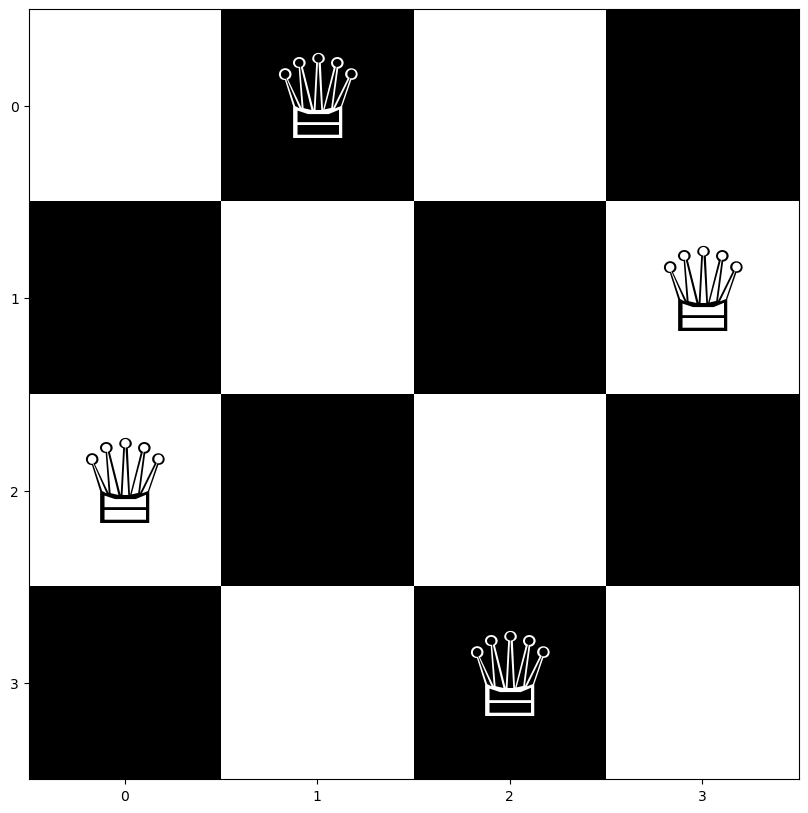

In [58]:
#| echo: false
#| label: fig-4-queens-sol
#| fig-cap: A 4-Queens solution

size = 4

solver = NQueensSolver(size)
solver.build_model()
solver.optimize()

coordinates = solver.get_queen_coordinates()
chessBoard = ChessBoard(size)
ax = chessBoard.display(coordinates)
plt.show(ax)

@fig-10-queens-sol shows a 10-Queens puzzle solution.

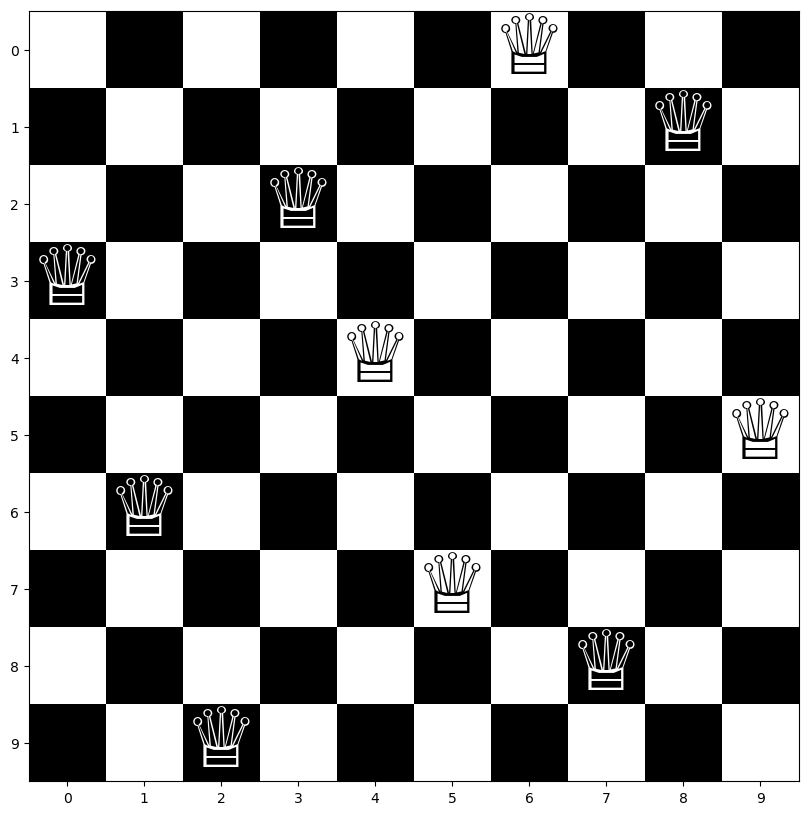

In [61]:
#| echo: false
#| label: fig-10-queens-sol
#| fig-cap: A 10-Queens solution

size = 10

solver = NQueensSolver(size)
solver.build_model()
solver.optimize()

coordinates = solver.get_queen_coordinates()
chessBoard = ChessBoard(size)
ax = chessBoard.display(coordinates)
plt.show(ax)

@fig-20-queens-sol shows a 20-Queens puzzle solution.

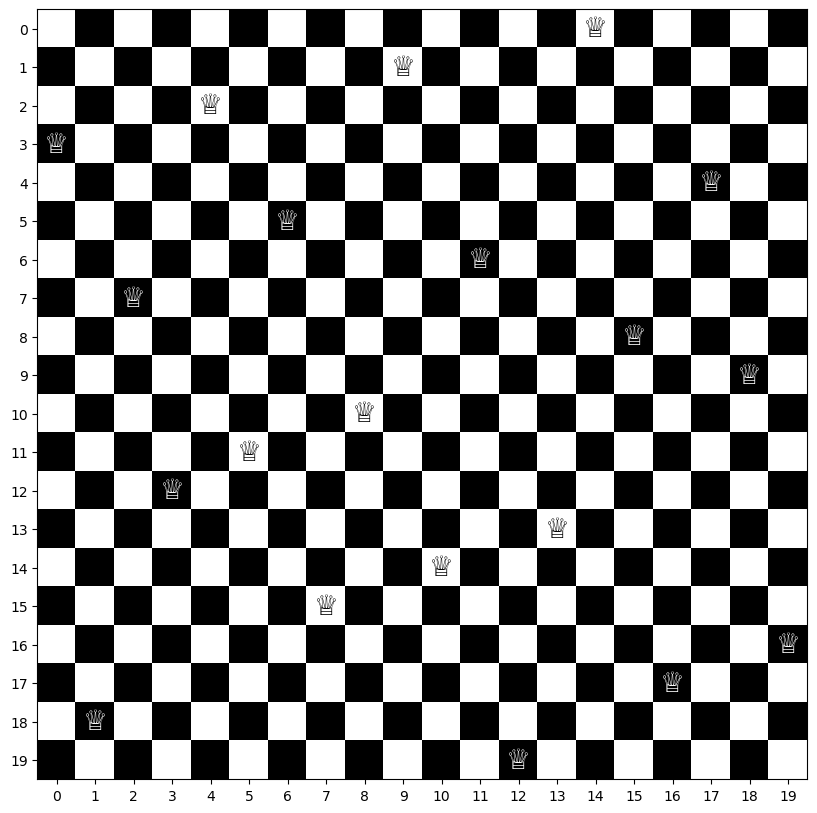

In [62]:
#| echo: false
#| label: fig-20-queens-sol
#| fig-cap: A 20-Queens solution

size = 20

solver = NQueensSolver(size)
solver.build_model()
solver.optimize()

coordinates = solver.get_queen_coordinates()
chessBoard = ChessBoard(size)
ax = chessBoard.display(coordinates)
plt.show(ax)